### Przewidywanie ceny domów. Celem projektu jest zastosowanie modeli regresji do przewidzenia ceny domu o podanych cechach.

Data: <b>12-05-2019</b> Imię i nazwisko: <b>Edyta Kudla</b><br><br>



Link do danych: <a href>web.stanford.edu/class/stats191/data/ames2000_NAfix.csv</a><br>
Dokładny opis danych: http://web.stanford.edu/class/stats191/data/amesdoc.txt<br><br>
Zmienna celu (cena domu): SalePrice

Wymagania dla projektu:
    
● Musi zostać wykorzystany model regresji liniowej.<br>
● Muszą zostać wykorzystane przynajmniej dwie inne metody regresji: regresja Ridge, regresja Lasso, drzewo regresyjne, las losowy regresyjny, XGBoost lub inne).<br>
● Trzeba uwzględnić optymalizację modeli/pipelinów.<br>
● Nie usuwamy żadnych obserwacji - braki danych uzupełniamy w jakiś sposób.<br>
● Wszelkie nieoczywiste przekształcenia danych należy opatrzyć uzasadnieniem dlaczego dokonujemy tego przekształcenia (np. robimy wykres i uzasadniamy wzięci logarytmu ze zmiennej tym, że rozkład jest skośny).<br>
● Musi pojawić się ocena graficzna predykcji modeli (np. wykresy wartości przewidywanych od prawdziwych czy wykresy reziduów).<br>
● Projekt musi być zakończony przejrzystym porównaniem przetestowanych rozwiązań (modeli/pipelinów) w postaci tabeli, gdzie jeden wiersz opisuje jedno rozwiązanie i jego wynik.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
import time
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
# from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.linear_model as lm
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import  metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
import warnings
warnings.filterwarnings('ignore')

C:\Users\Edyta\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Wczytanie i poznanie danych, które będą przedmiotem analizy

Wczytanie danych z pliku do obiektu Data Frame.

In [2]:
df = pd.read_csv('./data/ames2000_NAfix.csv')
df.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,...,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,None,None,0,9,2006,New,Partial,342643


In [3]:
df.shape

(2000, 80)

Ponieważ domyślnie obiekt Data Frame pokazuje tylko niektóre początkowe i końcowe kolumny, zwiększam parametry max_colums, max_rows co pozwoli przegląd pełnego zakresu danych, także po transpozycji.

In [4]:
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 80)

In [5]:
df.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,Twnhs,1Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,Stone,182,Gd,TA,PConc,Gd,TA,Av,ALQ,866,Unf,0,436,1302,GasA,Ex,Y,SBrkr,1302,0,0,1302,1,0,1,1,1,1,Gd,5,Typ,1,Gd,Attchd,2005,RFn,2,631,TA,TA,Y,110,50,0,0,0,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Nonemes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,SBrkr,882,0,0,882,1,0,1,0,2,1,TA,4,Typ,0,None,Attchd,1970,Fin,2,525,TA,TA,Y,240,0,0,0,0,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SFoyer,5,8,1972,2003,Gable,CompShg,WdShing,HdBoard,None,0,TA,Gd,CBlock,Gd,TA,Av,GLQ,660,Unf,0,108,768,GasA,Gd,Y,SBrkr,768,0,0,768,0,1,1,0,2,1,TA,5,Typ,0,None,Detchd,1974,Fin,1,396,TA,TA,Y,192,0,0,0,0,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,Slab,None,None,None,None,0,None,0,0,0,GasA,TA,Y,SBrkr,1535,0,0,1535,0,0,2,0,4,2,TA,8,Typ,0,None,Attchd,1979,Unf,2,400,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,370,TA,TA,PConc,Ex,Gd,Av,Unf,0,Unf,0,1249,1249,GasA,Ex,Y,SBrkr,1249,1347,0,2596,0,0,3,1,4,1,Gd,9,Typ,0,None,Attchd,2006,RFn,3,840,TA,TA,Y,240,154,0,0,0,0,None,None,None,0,9,2006,New,Partial,342643


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MS.SubClass,2000.0,56.9450,42.699281,20.0,20.00,50.0,70.00,190.0
Lot.Area,2000.0,10296.6650,8828.208491,1300.0,7500.00,9465.0,11500.00,215245.0
Overall.Qual,2000.0,6.0820,1.387169,1.0,5.00,6.0,7.00,10.0
Overall.Cond,2000.0,5.5740,1.105502,1.0,5.00,5.0,6.00,9.0
Year.Built,2000.0,1971.0795,29.985426,1872.0,1954.00,1972.0,2000.00,2010.0
Year.Remod.Add,2000.0,1984.0135,20.881771,1950.0,1965.00,1993.0,2004.00,2010.0
X1st.Flr.SF,2000.0,1158.7155,379.701015,407.0,877.75,1088.0,1391.25,4692.0
X2nd.Flr.SF,2000.0,334.3805,427.519973,0.0,0.00,0.0,703.25,2065.0
Low.Qual.Fin.SF,2000.0,4.3790,42.555738,0.0,0.00,0.0,0.00,697.0
Gr.Liv.Area,2000.0,1497.4750,498.561719,407.0,1126.75,1447.5,1734.00,5642.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
MS.SubClass        2000 non-null int64
MS.Zoning          2000 non-null object
Lot.Frontage       2000 non-null object
Lot.Area           2000 non-null int64
Street             2000 non-null object
Alley              2000 non-null object
Lot.Shape          2000 non-null object
Land.Contour       2000 non-null object
Utilities          2000 non-null object
Lot.Config         2000 non-null object
Land.Slope         2000 non-null object
Neighborhood       2000 non-null object
Condition.1        2000 non-null object
Condition.2        2000 non-null object
Bldg.Type          2000 non-null object
House.Style        2000 non-null object
Overall.Qual       2000 non-null int64
Overall.Cond       2000 non-null int64
Year.Built         2000 non-null int64
Year.Remod.Add     2000 non-null int64
Roof.Style         2000 non-null object
Roof.Matl          2000 non-null object
Exterior.1st       

### Kopia zapasowa danych

Przed rozpoczęciem transformacji danych tworzę kopię zapasową zbioru.

In [8]:
df_copy = df.copy()
df_copy.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,Twnhs,1Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,Stone,182,Gd,TA,PConc,Gd,TA,Av,ALQ,866,Unf,0,436,1302,GasA,Ex,Y,SBrkr,1302,0,0,1302,1,0,1,1,1,1,Gd,5,Typ,1,Gd,Attchd,2005,RFn,2,631,TA,TA,Y,110,50,0,0,0,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Nonemes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,SBrkr,882,0,0,882,1,0,1,0,2,1,TA,4,Typ,0,None,Attchd,1970,Fin,2,525,TA,TA,Y,240,0,0,0,0,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SFoyer,5,8,1972,2003,Gable,CompShg,WdShing,HdBoard,None,0,TA,Gd,CBlock,Gd,TA,Av,GLQ,660,Unf,0,108,768,GasA,Gd,Y,SBrkr,768,0,0,768,0,1,1,0,2,1,TA,5,Typ,0,None,Detchd,1974,Fin,1,396,TA,TA,Y,192,0,0,0,0,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,Slab,None,None,None,None,0,None,0,0,0,GasA,TA,Y,SBrkr,1535,0,0,1535,0,0,2,0,4,2,TA,8,Typ,0,None,Attchd,1979,Unf,2,400,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,370,TA,TA,PConc,Ex,Gd,Av,Unf,0,Unf,0,1249,1249,GasA,Ex,Y,SBrkr,1249,1347,0,2596,0,0,3,1,4,1,Gd,9,Typ,0,None,Attchd,2006,RFn,3,840,TA,TA,Y,240,154,0,0,0,0,None,None,None,0,9,2006,New,Partial,342643


### Oczyszczanie danych - usuwanie braków oraz wartości null

W pierwszej kolejności sprawdzam, w których kolumnach występują wartości null, czyli 'NaN'.

In [9]:
def containsNulls(df):
    contains_nulls = df.columns[df.isna().any() == True]
    return contains_nulls

In [10]:
contains_nulls = containsNulls(df)
contains_nulls

Index(['Mas.Vnr.Type', 'Bsmt.Qual', 'Bsmt.Cond', 'Bsmt.Exposure',
       'BsmtFin.Type.1', 'BsmtFin.Type.2', 'Garage.Finish', 'Garage.Qual',
       'Garage.Cond'],
      dtype='object')

Istnieje 9 kolumn zawierających wartości null. Braki dotyczą cech piwnicy i garażu oraz forniru murarskiego. W kolejnym kroku sprawdzam jakie są unikalne wartości dla tych kolumn.

In [11]:
def uniqueValuesInContainsNulls(df, list):
    for item in list:
        print(item, ':', df[item].unique())

In [12]:
uniqueValuesInContainsNulls(df, contains_nulls)

Mas.Vnr.Type : ['Stone' 'None' 'BrkFace' nan 'BrkCmn' 'CBlock']
Bsmt.Qual : ['Gd' 'TA' 'None' 'Ex' 'Fa' nan 'Po']
Bsmt.Cond : ['TA' 'None' 'Gd' 'Fa' 'Ex' nan 'Po']
Bsmt.Exposure : ['Av' 'No' 'None' 'Gd' 'Mn' nan]
BsmtFin.Type.1 : ['ALQ' 'GLQ' 'None' 'Unf' 'LwQ' 'Rec' 'BLQ' nan]
BsmtFin.Type.2 : ['Unf' 'Rec' 'None' 'GLQ' 'ALQ' 'LwQ' 'BLQ' nan]
Garage.Finish : ['RFn' 'Fin' 'Unf' 'None' nan]
Garage.Qual : ['TA' 'None' 'Fa' 'Gd' nan 'Po' 'Ex']
Garage.Cond : ['TA' 'None' 'Gd' 'Fa' 'Po' nan 'Ex']


Po analizie list wartości dla poszczególnych pól przyjmuję założenie, że brak informacji oznaczać będzie brak cechy. Dlatego brakujące wartości zostaną uzupełnione wartością None.

In [13]:
def fillNullByNone(df, contains_nulls):
    for item in contains_nulls:
        df[item] = df[item].fillna('None')

In [14]:
fillNullByNone(df, contains_nulls)

Ponowne sprawdzam, czy wszystkie modyfikowane kolumny zawierają wartości różne od null.

In [15]:
df[contains_nulls].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
Mas.Vnr.Type      2000 non-null object
Bsmt.Qual         2000 non-null object
Bsmt.Cond         2000 non-null object
Bsmt.Exposure     2000 non-null object
BsmtFin.Type.1    2000 non-null object
BsmtFin.Type.2    2000 non-null object
Garage.Finish     2000 non-null object
Garage.Qual       2000 non-null object
Garage.Cond       2000 non-null object
dtypes: object(9)
memory usage: 140.7+ KB


W zbiorze obecnie brak już wartości null. Sprawdzam liczbę unikalnych wartości dla każdej z kolumn.

In [16]:
def dfTypesAndUniques(df):
    types = df.dtypes
    nunique = df.nunique()
    df_info = pd.DataFrame(pd.concat([types, nunique], axis =1))
    df_info = df_info.rename(columns={0:'Type', 1:'Num_unique'}).sort_values(by='Num_unique', ascending=False)
    return df_info

In [17]:
df_info = dfTypesAndUniques(df)
df_info

,Type,Num_unique
Lot.Area,int64,1424
Gr.Liv.Area,int64,1051
Bsmt.Unf.SF,object,928
X1st.Flr.SF,int64,902
Total.Bsmt.SF,object,871
BsmtFin.SF.1,object,817
SalePrice,int64,812
Garage.Area,object,531
X2nd.Flr.SF,int64,500
Mas.Vnr.Area,object,363


Rozdzielam dane numeryczne od tekstowych. 

In [18]:
def numericAndTextData(df_info):
    df_numeric = df_info[df_info['Type'] == 'int64']
    df_text = df_info[df_info['Type'] == 'object']
    print(f'Amount of numeric data: {len(df_numeric)}, Amount of text data: {len(df_text)}')

    numeric = df_numeric.index
    text = df_text.index
    return (numeric, text)

In [19]:
numeric, text = numericAndTextData(df_info)
print(f'Numeric columns: {numeric}')
print(f'Text columns: {text}')

Amount of numeric data: 26, Amount of text data: 54
Numeric columns: Index(['Lot.Area', 'Gr.Liv.Area', 'X1st.Flr.SF', 'SalePrice', 'X2nd.Flr.SF',
       'Wood.Deck.SF', 'Open.Porch.SF', 'Enclosed.Porch', 'Year.Built',
       'Screen.Porch', 'Year.Remod.Add', 'Misc.Val', 'Low.Qual.Fin.SF',
       'X3Ssn.Porch', 'MS.SubClass', 'Mo.Sold', 'Pool.Area', 'TotRms.AbvGrd',
       'Overall.Qual', 'Overall.Cond', 'Bedroom.AbvGr', 'Fireplaces',
       'Full.Bath', 'Yr.Sold', 'Kitchen.AbvGr', 'Half.Bath'],
      dtype='object')
Text columns: Index(['Bsmt.Unf.SF', 'Total.Bsmt.SF', 'BsmtFin.SF.1', 'Garage.Area',
       'Mas.Vnr.Area', 'BsmtFin.SF.2', 'Lot.Frontage', 'Garage.Yr.Blt',
       'Neighborhood', 'Exterior.2nd', 'Exterior.1st', 'Sale.Type',
       'Condition.1', 'House.Style', 'Functional', 'Garage.Type',
       'Garage.Cars', 'MS.Zoning', 'Condition.2', 'Roof.Matl',
       'BsmtFin.Type.2', 'BsmtFin.Type.1', 'Heating', 'Roof.Style',
       'Garage.Cond', 'Bsmt.Cond', 'Bsmt.Qual', 'Fireplac

Sprawdzam, czy wśród kolumn tekstowych znajdują się podejrzane kolumny, którym należy im się przyjrzeć bliżej.

In [20]:
def checkTextValues(df, text_columns_list):
    for item in text_columns_list:
        print(item, ':', df[item].unique())

In [21]:
checkTextValues(df, text)

Bsmt.Unf.SF : ['436' '0' '108' '1249' '560' '576' '125' '634' '912' '894' '305' '869'
 '970' '636' '1836' '195' '497' '526' '726' '1615' '100' '768' '253' '94'
 '398' '1028' '440' '34' '331' '240' '860' '210' '466' '589' '286' '994'
 '918' '1348' '434' '715' '140' '384' '794' '1459' '99' '354' '127' '244'
 '1696' '1264' '704' '201' '686' '662' '1141' '455' '1005' '1632' '252'
 '1421' '171' '1541' '1580' '460' '268' '169' '896' '938' '1420' '960'
 '903' '849' '307' '237' '162' '1686' '130' '399' '1181' '784' '414'
 '1280' '564' '115' '1008' '92' '710' '917' '1560' '1040' '585' '52' '386'
 '491' '1286' '200' '1026' '534' '1228' '144' '728' '675' '238' '480'
 '160' '1242' '1088' '884' '458' '637' '182' '278' '578' '355' '280' '300'
 '413' '756' '746' '658' '724' '544' '103' '1680' '880' '712' '1357' '161'
 '325' '378' '176' '750' '245' '290' '808' '522' '133' '664' '192' '672'
 '939' '132' '731' '113' '1528' '308' '625' '484' '223' '1694' '28' '718'
 '476' '415' '770' '420' '630' '126' '8

BsmtFin.SF.1 : ['866' '804' '660' '0' '51' '1400' '73' '249' '595' '787' '1684' '24'
 '533' '491' '1274' '810' '554' '392' '791' '1033' '210' '256' '901' '594'
 '336' '784' '745' '400' '790' '773' '248' '701' '1036' '283' '666' '678'
 '495' '548' '892' '663' '455' '276' '468' '720' '1238' '1567' '788' '536'
 '134' '1104' '617' '776' '939' '588' '696' '593' '381' '450' '192' '132'
 '604' '250' '63' '200' '871' '311' '251' '840' '170' '1021' '841' '633'
 '371' '813' '403' '448' '524' '472' '483' '261' '140' '538' '1260' '812'
 '2158' '1159' '228' '1249' '16' '831' '864' '673' '648' '528' '466' '266'
 '686' '226' '644' '655' '53' '1324' '264' '1088' '279' '1358' '68' '288'
 '476' '1180' '335' '315' '800' '1070' '560' '1220' '736' '259' '162'
 '456' '435' '716' '512' '374' '1075' '870' '1053' '625' '104' '624' '252'
 '626' '378' '394' '292' '334' '353' '687' '262' '467' '697' '356' '454'
 '1277' '766' '649' '1163' '621' '155' '672' '867' '515' '664' '922' '384'
 '608' '1573' '1337' '414' '

Okazuje się, że wśród danych tekstowych znalazły się także kolumny zawierające tak naprawdę dane numeryczne, ale także wartość 'None'. 
W przypadku kolumn 'Bsmt.Unf.SF', 'Total.Bsmt.SF', 'BsmtFin.SF.1', 'Garage.Area', 'Mas.Vnr.Area', 'BsmtFin.SF.2', cechy garażu i piwnicy z wartością 'None' zostaną zastąpione wartością 0. Dane w wymienionych kolumnach są podawane w jednostce SF (stopy kwadratowe), dlatego zamiana na zero nie wpłynie na interpretację danych.

Po zamianie wartości, zmieniony zostanie także typ kolumny na int64. Krok jest niezbędny do kolejnego etapu - wytrenowania modelu. 

In [22]:
def changeNoneToZeroForAreasData(df, lst):
    for item in lst:
        df.loc[df[item][df[item] == 'None'].index, item ] = 0
        df[item] = df[item].astype('int64')
    return

In [23]:
lst_zero = ['Bsmt.Unf.SF', 'Total.Bsmt.SF', 'BsmtFin.SF.1', 'Garage.Area', 'Mas.Vnr.Area', 'BsmtFin.SF.2']
changeNoneToZeroForAreasData(df, lst_zero)

Kolumna 'Lot.Frontage' oznacza liczbę stóp od ulicy, nie można zatem wstawić zera, gdyż żaden dom nie może stać na krawędzi ulicy. W celu uzupełnienia danych zostanie wstawiona średnia liczba stóp od ulicy, wyliczona z danych pozostałych domów. Następnie typ danych również zostanie zamieniony na typ int64.

In [24]:
def changeNoneToMeanForNotAreaData(df, lst):
    for item in lst:
        get_item_values = df[item][df[item] != 'None'].values
        item_mean = get_item_values.astype(np.int64).mean().astype(np.int64)
        df.loc[df[item][df[item] == 'None'].index, item] = item_mean
        df[item] = df[item].astype('int64')
    return item_mean

In [25]:
lst_mean = ['Lot.Frontage']
changeNoneToMeanForNotAreaData(df, lst_mean)

69

W przypadku kolumny 'Garage.Yr.Blt' jako rok budowy garażu, dla budynków, dla których nie podano tej wartości, zostanie przyjęty rok budowy danego budynku tzn. 'Year.Built'. Typ danych tutaj także zostanie zamieniony na int64.

In [26]:
def changeNoneToYear(df, lst, year):
    for item in lst:
        df.loc[df[item][df[item] == 'None'].index, item] = df.loc[df[item][df[item] == 'None'].index, year]
        df[item] = df[item].astype('int64')
    return

In [27]:
lst_year = ['Garage.Yr.Blt']
year = 'Year.Built'
changeNoneToYear(df,lst_year, year)

In [28]:
df_info = dfTypesAndUniques(df)
numeric, text = numericAndTextData(df_info)
print(f'Numeric columns: {numeric}')
print(f'Text columns: {text}')

Amount of numeric data: 34, Amount of text data: 46
Numeric columns: Index(['Lot.Area', 'Gr.Liv.Area', 'Bsmt.Unf.SF', 'X1st.Flr.SF',
       'Total.Bsmt.SF', 'BsmtFin.SF.1', 'SalePrice', 'Garage.Area',
       'X2nd.Flr.SF', 'Mas.Vnr.Area', 'Wood.Deck.SF', 'Open.Porch.SF',
       'BsmtFin.SF.2', 'Enclosed.Porch', 'Lot.Frontage', 'Year.Built',
       'Garage.Yr.Blt', 'Screen.Porch', 'Year.Remod.Add', 'Misc.Val',
       'Low.Qual.Fin.SF', 'X3Ssn.Porch', 'MS.SubClass', 'Mo.Sold', 'Pool.Area',
       'TotRms.AbvGrd', 'Overall.Qual', 'Overall.Cond', 'Bedroom.AbvGr',
       'Fireplaces', 'Full.Bath', 'Yr.Sold', 'Kitchen.AbvGr', 'Half.Bath'],
      dtype='object')
Text columns: Index(['Neighborhood', 'Exterior.2nd', 'Exterior.1st', 'Sale.Type',
       'Condition.1', 'House.Style', 'Functional', 'Garage.Type',
       'Garage.Cars', 'MS.Zoning', 'Condition.2', 'Roof.Matl',
       'BsmtFin.Type.2', 'BsmtFin.Type.1', 'Heating', 'Roof.Style',
       'Garage.Cond', 'Bsmt.Cond', 'Bsmt.Qual', 'Fireplac

W kolejnym kroku analizie zostaną poddane dane tekstowe. Sprawdzam jakie wartości unikalne występują dla każdej z kolumn.

In [29]:
for item in text:
    print(item, ':', df[item].unique())

Neighborhood : ['NridgHt' 'Nonemes' 'CollgCr' 'SawyerW' 'Sawyer' 'ClearCr' 'OldTown'
 'SWISU' 'Crawfor' 'Edwards' 'Timber' 'Gilbert' 'NoRidge' 'NWAmes'
 'BrkSide' 'Somerst' 'StoneBr' 'IDOTRR' 'Mitchel' 'MeadowV' 'NPkVill'
 'Blmngtn' 'Veenker' 'BrDale' 'Greens' 'Blueste' 'GrnHill']
Exterior.2nd : ['VinylSd' 'Plywood' 'HdBoard' 'MetalSd' 'Wd Sdng' 'Stucco' 'CmentBd'
 'Wd Shng' 'ImStucc' 'Stone' 'BrkFace' 'AsbShng' 'Brk Cmn' 'CBlock'
 'AsphShn' 'Other']
Exterior.1st : ['VinylSd' 'Plywood' 'WdShing' 'MetalSd' 'Wd Sdng' 'HdBoard' 'CemntBd'
 'BrkFace' 'Stucco' 'BrkComm' 'AsbShng' 'CBlock' 'AsphShn' 'Stone']
Sale.Type : ['New' 'WD ' 'COD' 'CWD' 'ConLD' 'ConLI' 'Oth' 'Con' 'ConLw' 'VWD']
Condition.1 : ['Norm' 'Feedr' 'RRAn' 'Artery' 'PosN' 'PosA' 'RRAe' 'RRNn' 'RRNe']
House.Style : ['1Story' 'SFoyer' '2Story' '1.5Fin' 'SLvl' '1.5Unf' '2.5Unf' '2.5Fin']
Functional : ['Typ' 'Min2' 'Maj1' 'Min1' 'Sev' 'Mod' 'Maj2']
Garage.Type : ['Attchd' 'Detchd' 'CarPort' 'None' '2Types' 'Basment' 'BuiltIn']
Ga

Zgodnie z opisem danych, niektóre z kolumn opisanych jako typ 'Ordinal' powinny po transformacji zachować porządek.
Tymi kolumnami są:
'Lot.Shape', 'Land.Slope', 'Exter.Cond', 'Exter.Qual', 'Bsmt.Cond', 'Bsmt.Qual', 'Electrical', 'Kitchen.Qual', 'Functional', 'Fireplace.Qu', 'Garage.Finish', 'Garage.Cond', 'Garage.Qual', 'Paved.Drive', 'Pool.QC', 'Fence'.

W związku z tym, dla każdej z nich mapowanie na wartości numeryczne zostanie wykonane wg słowników. Słowniki tworzę w oparciu o opis danych.

In [30]:
ordinal_lst = ['Lot.Shape', 
                'Land.Slope', 
                'Exter.Cond', 
                'Exter.Qual', 
                'Bsmt.Cond', 
                'Bsmt.Qual', 
                'Electrical', 
                'Kitchen.Qual', 
                'Functional', 
                'Fireplace.Qu', 
                'Garage.Finish', 
                'Garage.Cond', 
                'Garage.Qual', 
                'Paved.Drive', 
                'Pool.QC', 
                'Fence']

ordinal_dicts = [{'Reg':0, 'IR1':1, 'IR2':2, 'IR3':3}, 
                 {'Gtl':0, 'Mod':1, 'Sev':2}, 
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'Mix':0, 'FuseP':1, 'FuseF':2, 'FuseA':3, 'SBrkr':4},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'Typ':0, 'Min1':1, 'Min2':2, 'Mod':3, 'Maj1':4, 'Maj2':5, 'Sev':6, 'Sal':7},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'None':0, 'Unf':1, 'RFn':2, 'Fin':3},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'N':0, 'P':1, 'Y':2},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'None':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}]
                 

Argumentami funkcji pozwalającymi na zamianę wartości będą obiekt DataFrame, lista kolumn podlegająca zmianie i lista wartości słownika dla każdej z kolumny.

In [31]:
def changeTextToOrdinalNumber(df, columns_lst, dicts):
  
    i = 0
    for item in columns_lst:
        changed = {columns_lst[i] : dicts[i]}
        df.replace(changed, inplace=True)
        i += 1
    return df    

In [32]:
changeTextToOrdinalNumber(df, ordinal_lst, ordinal_dicts)
df.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,0,Lvl,AllPub,Inside,0,NridgHt,Norm,Norm,Twnhs,1Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,Stone,182,4,3,PConc,4,3,Av,ALQ,866,Unf,0,436,1302,GasA,Ex,Y,4,1302,0,0,1302,1,0,1,1,1,1,4,5,0,1,4,Attchd,2005,2,2,631,3,3,2,110,50,0,0,0,0,0,0,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,0,Lvl,AllPub,Corner,0,Nonemes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,3,3,CBlock,3,3,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,4,882,0,0,882,1,0,1,0,2,1,3,4,0,0,0,Attchd,1970,3,2,525,3,3,2,240,0,0,0,0,0,0,3,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,0,Lvl,AllPub,Inside,0,CollgCr,Norm,Norm,1Fam,SFoyer,5,8,1972,2003,Gable,CompShg,WdShing,HdBoard,None,0,3,4,CBlock,4,3,Av,GLQ,660,Unf,0,108,768,GasA,Gd,Y,4,768,0,0,768,0,1,1,0,2,1,3,5,0,0,0,Detchd,1974,3,1,396,3,3,2,192,0,0,0,0,0,0,3,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,0,Bnk,AllPub,Inside,0,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,Plywood,Plywood,None,0,3,3,Slab,0,0,None,None,0,None,0,0,0,GasA,TA,Y,4,1535,0,0,1535,0,0,2,0,4,2,3,8,0,0,0,Attchd,1979,1,2,400,3,3,2,0,0,0,0,0,0,0,0,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,0,Lvl,AllPub,Corner,0,NridgHt,Norm,Norm,1Fam,2Story,9,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,370,3,3,PConc,5,4,Av,Unf,0,Unf,0,1249,1249,GasA,Ex,Y,4,1249,1347,0,2596,0,0,3,1,4,1,4,9,0,0,0,Attchd,2006,2,3,840,3,3,2,240,154,0,0,0,0,0,0,None,0,9,2006,New,Partial,342643


Kolumny z wartościami tekstowymi wymagające zachowania porządku, zostału zamienione na numeryczne. Dla pozostałych kolumn tekstowych, po zapoznaniu z opisem danych, przyjmuję założenie, że porządek nie ma znaczenia.

Korzystam z metody LabelEncoder, która pozwoli na zamianę wskazanych kategorii tekstowych na numeryczne.

In [33]:
def changeObjectValueToNumber(df): 
    for item in df.columns:
        if df[item].dtype == 'object':
            le = preprocessing.LabelEncoder()
            df[item] = le.fit_transform(df[item].astype('str'))
    return

In [34]:
changeObjectValueToNumber(df)

In [35]:
df.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,5,34,3901,1,1,0,3,0,4,0,18,2,2,3,2,6,5,2005,2006,1,1,11,13,4,182,4,3,2,4,3,0,0,866,6,0,436,1302,1,0,1,4,1302,0,0,1302,1,0,1,1,1,1,4,5,0,1,4,1,2005,2,2,631,3,3,2,110,50,0,0,0,0,0,0,1,0,8,2007,6,5,204000
1,20,5,70,8400,1,1,0,3,0,0,0,17,2,2,0,2,4,5,1970,1970,1,1,8,10,3,0,3,3,1,3,3,3,0,804,5,78,0,882,1,4,1,4,882,0,0,882,1,0,1,0,2,1,3,4,0,0,0,1,1970,3,2,525,3,3,2,240,0,0,0,0,0,0,3,1,0,4,2010,9,4,126000
2,85,5,60,7200,1,1,0,3,0,4,0,5,2,2,0,6,5,8,1972,2003,1,1,13,6,3,0,3,4,1,4,3,0,2,660,6,0,108,768,1,2,1,4,768,0,0,768,0,1,1,0,2,1,3,5,0,0,0,5,1974,3,1,396,3,3,2,192,0,0,0,0,0,0,3,1,0,4,2009,9,4,133900
3,90,5,64,7018,1,1,0,0,0,4,0,22,2,2,2,2,5,5,1979,1979,1,1,8,10,3,0,3,3,3,0,0,4,4,0,4,0,0,0,1,4,1,4,1535,0,0,1535,0,0,2,0,4,2,3,8,0,0,0,1,1979,1,2,400,3,3,2,0,0,0,0,0,0,0,0,1,0,6,2009,9,2,118858
4,60,5,111,16259,1,1,0,3,0,0,0,18,2,2,0,5,9,5,2006,2006,1,1,11,13,4,370,3,3,2,5,4,0,6,0,6,0,1249,1249,1,0,1,4,1249,1347,0,2596,0,0,3,1,4,1,4,9,0,0,0,1,2006,2,3,840,3,3,2,240,154,0,0,0,0,0,0,1,0,9,2006,6,5,342643


Sprawdzam czy wartości unikalne dla każdej z kolumn na pewno są już wartościami numerycznymi.

In [36]:
for item in text:
    print(item, ':', df[item].unique())

Neighborhood : [18 17  5 22 21  4 19 20  6  7 25  8 16 15  3 23 24 11 13 12 14  0 26  2
  9  1 10]
Exterior.2nd : [13 10  6  8 14 12  5 15  7 11  3  0  2  4  1  9]
Exterior.1st : [11  8 13  7 12  6  5  3 10  2  0  4  1  9]
Sale.Type : [6 9 0 1 3 4 7 2 5 8]
Condition.1 : [2 1 6 0 4 3 5 8 7]
House.Style : [2 6 5 0 7 1 4 3]
Functional : [0 2 4 1 6 3 5]
Garage.Type : [1 5 4 6 0 2 3]
Garage.Cars : [2 1 3 0 5 4 6]
MS.Zoning : [5 6 1 2 3 0 4]
Condition.2 : [2 4 5 0 1 3 6]
Roof.Matl : [1 6 4 5 0 3 2]
BsmtFin.Type.2 : [6 5 4 2 0 3 1]
BsmtFin.Type.1 : [0 2 4 6 3 5 1]
Heating : [1 2 5 4 3 0]
Roof.Style : [1 5 2 0 3 4]
Garage.Cond : [3 0 4 2 1 5]
Bsmt.Cond : [3 0 4 2 5 1]
Bsmt.Qual : [4 3 0 5 2 1]
Fireplace.Qu : [4 0 2 3 5 1]
Foundation : [2 1 3 0 4 5]
Sale.Condition : [5 4 2 0 3 1]
Garage.Qual : [3 0 2 4 1 5]
Pool.QC : [0 5 2 3 4]
Mas.Vnr.Type : [4 3 1 0 2]
Fence : [0 3 4 2 1]
Misc.Feature : [1 3 4 0 2]
Bsmt.Full.Bath : [1 0 2 4 3]
Bldg.Type : [3 0 2 1 4]
Heating.QC : [0 4 2 1 3]
Bsmt.Exposure : 

Ponownie sprawdzam typy danych oraz liczbę wartości unikalnych dla każdej z kolumn.

In [37]:
df_info = dfTypesAndUniques(df)
df_info

,Type,Num_unique
Lot.Area,int64,1424
Gr.Liv.Area,int64,1051
Bsmt.Unf.SF,int64,927
X1st.Flr.SF,int64,902
Total.Bsmt.SF,int64,870
BsmtFin.SF.1,int64,816
SalePrice,int64,812
Garage.Area,int64,530
X2nd.Flr.SF,int64,500
Mas.Vnr.Area,int64,362


Ponieważ w kolumnie 'Utilities' istnieje tylko jedna wartość w całym zbiorze, to usuwam ją. Nie ma wpływu na dalszą analizę.

In [38]:
df.drop(['Utilities'], axis=1, inplace=True)
df.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,5,34,3901,1,1,0,3,4,0,18,2,2,3,2,6,5,2005,2006,1,1,11,13,4,182,4,3,2,4,3,0,0,866,6,0,436,1302,1,0,1,4,1302,0,0,1302,1,0,1,1,1,1,4,5,0,1,4,1,2005,2,2,631,3,3,2,110,50,0,0,0,0,0,0,1,0,8,2007,6,5,204000
1,20,5,70,8400,1,1,0,3,0,0,17,2,2,0,2,4,5,1970,1970,1,1,8,10,3,0,3,3,1,3,3,3,0,804,5,78,0,882,1,4,1,4,882,0,0,882,1,0,1,0,2,1,3,4,0,0,0,1,1970,3,2,525,3,3,2,240,0,0,0,0,0,0,3,1,0,4,2010,9,4,126000
2,85,5,60,7200,1,1,0,3,4,0,5,2,2,0,6,5,8,1972,2003,1,1,13,6,3,0,3,4,1,4,3,0,2,660,6,0,108,768,1,2,1,4,768,0,0,768,0,1,1,0,2,1,3,5,0,0,0,5,1974,3,1,396,3,3,2,192,0,0,0,0,0,0,3,1,0,4,2009,9,4,133900
3,90,5,64,7018,1,1,0,0,4,0,22,2,2,2,2,5,5,1979,1979,1,1,8,10,3,0,3,3,3,0,0,4,4,0,4,0,0,0,1,4,1,4,1535,0,0,1535,0,0,2,0,4,2,3,8,0,0,0,1,1979,1,2,400,3,3,2,0,0,0,0,0,0,0,0,1,0,6,2009,9,2,118858
4,60,5,111,16259,1,1,0,3,0,0,18,2,2,0,5,9,5,2006,2006,1,1,11,13,4,370,3,3,2,5,4,0,6,0,6,0,1249,1249,1,0,1,4,1249,1347,0,2596,0,0,3,1,4,1,4,9,0,0,0,1,2006,2,3,840,3,3,2,240,154,0,0,0,0,0,0,1,0,9,2006,6,5,342643


### Podsumowanie etapu czyszczenia zbioru danych - za pomocą jednej funkcji

Reasumując, przed rozpoczęciem trenowania modelu należałoby oczyścić dane, na przykład w taki sposób aby puste wartości zastąpić wartością domyślną 'None' lub średnią z istniejących danych.
W tym celu wystarczy nowy zbiór danych przepuścić przez metodę:

In [39]:
def cleaningData(df):
    lst_nulls = ['Mas.Vnr.Type', 'Bsmt.Qual', 'Bsmt.Cond', 'Bsmt.Exposure','BsmtFin.Type.1', 'BsmtFin.Type.2', 
                 'Garage.Finish', 'Garage.Qual','Garage.Cond']
    lst_zero = ['Bsmt.Unf.SF', 'Total.Bsmt.SF', 'BsmtFin.SF.1', 'Garage.Area', 'Mas.Vnr.Area', 'BsmtFin.SF.2']
    lst_mean = ['Lot.Frontage']
    lst_year = ['Garage.Yr.Blt']
    year = 'Year.Built'

    fillNullByNone(df, lst_nulls)
    changeNoneToZeroForAreasData(df, lst_zero)
    changeNoneToMeanForNotAreaData(df, lst_mean)
    changeNoneToYear(df,lst_year, year)
    changeObjectValueToNumber(df)
    changeTextToOrdinalNumber(df, ordinal_lst, ordinal_dicts)
    result = dfTypesAndUniques(df)
    return result

### Korelacje liniowe

Przed rozpoczęciem uczenia modelu, sprawdzam co jeszcze można wyciągnąć z badanego zbioru danych - czy występują jakieś korelacje liniowe.

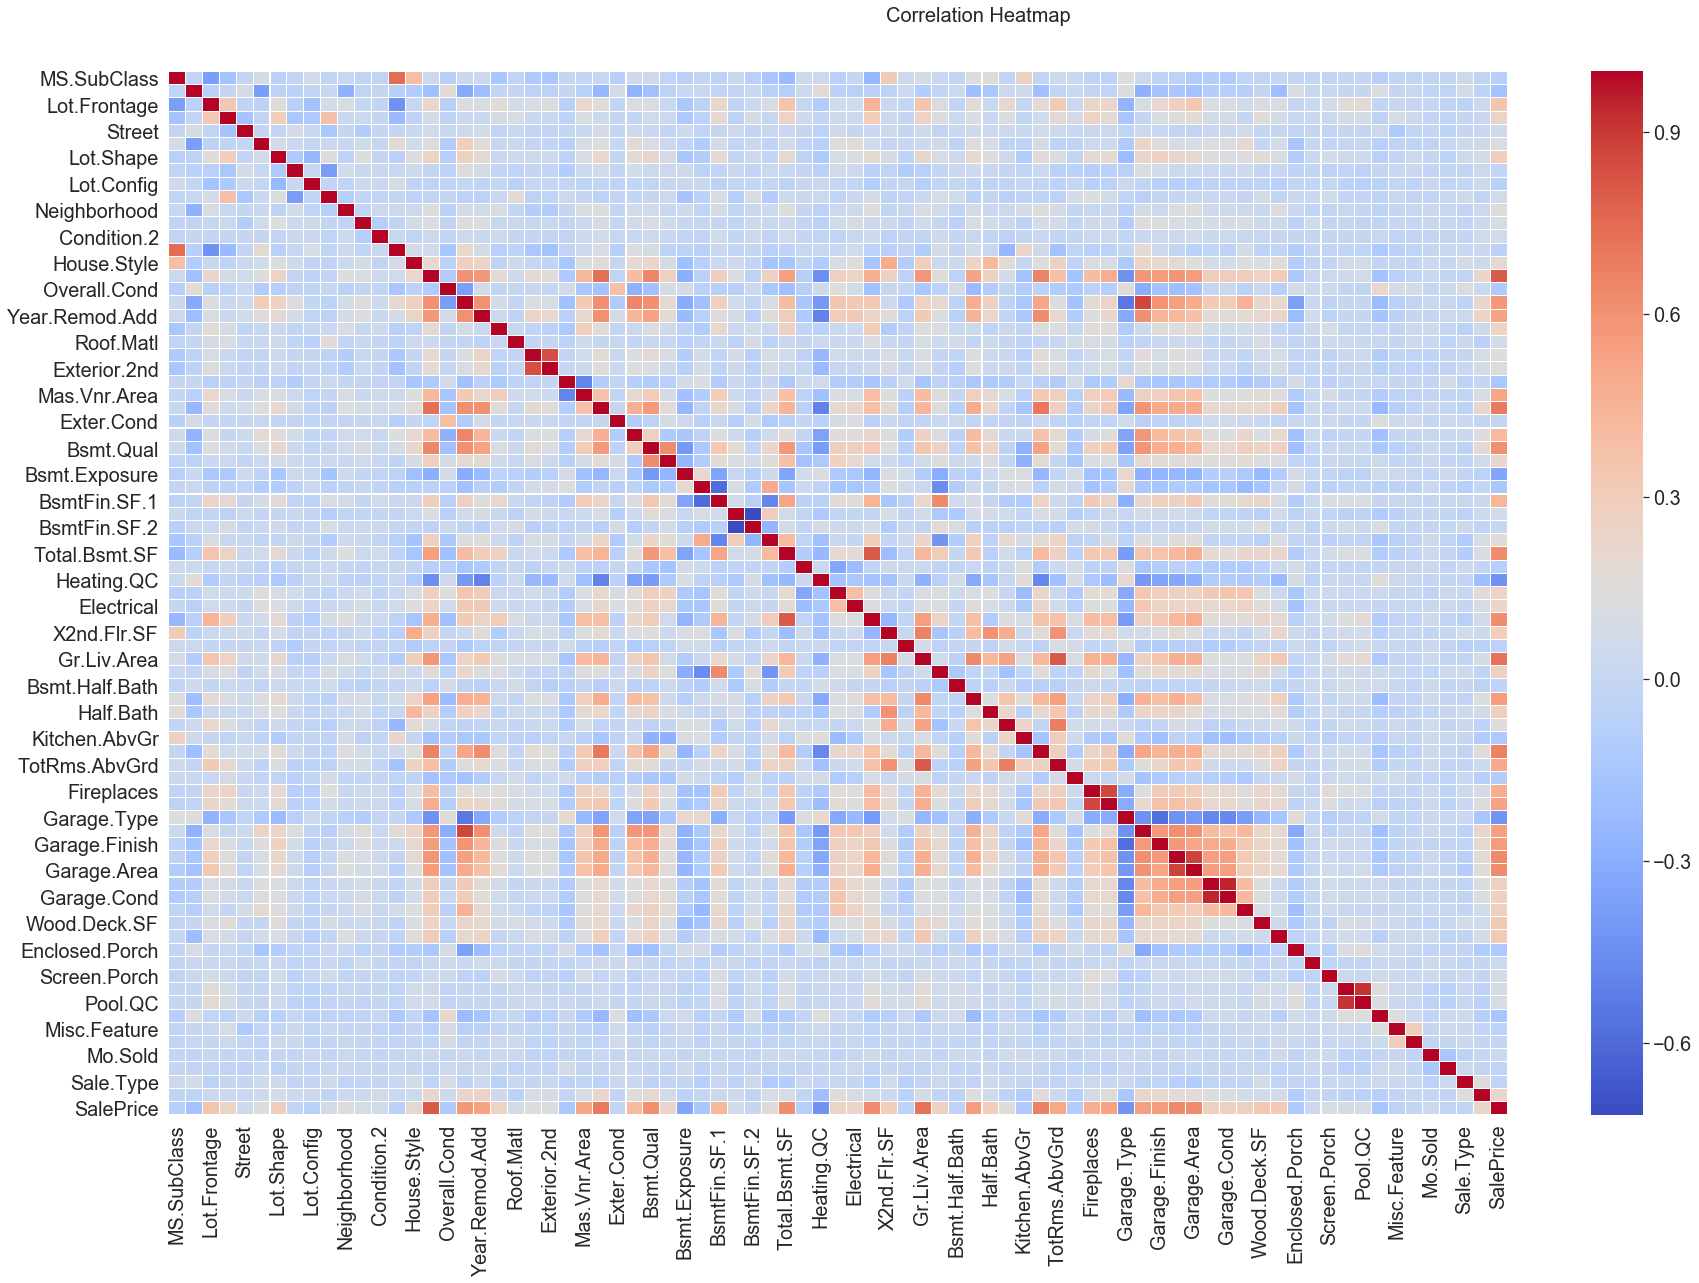

In [40]:
sns.set(style='darkgrid', font_scale=1.8)
fig, ax = plt.subplots(figsize=(30, 18))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm",fmt='.2f',linewidths=.05 )
fig.subplots_adjust(top=0.93)
fig.suptitle('Correlation Heatmap', fontsize=20)
plt.show()

Sprawdzam, które kolumny są najbardziej skorelowane z 'SalePrice', tzn. powyżej 0.50 lub poniżej -0.50

In [41]:
df_most_correlated_cols = pd.DataFrame(df.corr().SalePrice.sort_values())
df_most_correlated_cols = df_most_correlated_cols[df_most_correlated_cols['SalePrice'].between(-0.50, 0.50, inclusive = False) == False]
df_most_correlated_cols

,SalePrice
TotRms.AbvGrd,0.504280
Mas.Vnr.Area,0.514974
Fireplace.Qu,0.532538
Year.Remod.Add,0.534962
Garage.Yr.Blt,0.541022
Garage.Finish,0.559978
Full.Bath,0.561228
Year.Built,0.571716
Bsmt.Qual,0.616290
X1st.Flr.SF,0.619121


Przedmiotem analizy jest przede wszystkim znalezienie korelacji zmiennej 'SalePrice' z innymi zmiennymi. Jednakże na heatmapie można zauważyć szereg innych korelacji, m.in. ogólnego stanu domu ('Overall.Cond) do roku budowy ('Year.Built').

Można zauważyć pozytywne korelacje liniowe (powyżej 0.50) zmiennej 'SalePrice' ze zmniennymi:
'TotRms.AbvGrd', 'Mas.Vnr.Area','Fireplace.Qu', 'Year.Remod.Add', 'Garage.Yr.Blt', 'Garage.Finish', 'Full.Bath', 'Year.Built', 'Bsmt.Qual', 'X1st.Flr.SF', 'Total.Bsmt.SF', 'Garage.Area', 'Garage.Cars', 'Kitchen.Qual', 'Exter.Qual', 'Gr.Liv.Area', 'Overall.Qual'.

Wniosek:
Największe znaczenie ma ogólny stan domu, garażu, piwnicy, kuchni, a także metraże poszczególnych elementów.

Najsilniejsza jest korelacja ceny 'SalePrice' z 'Overall.Qual'.

Weryfikuję jak korelacje wyglądają na pairplocie. Dla lepszego zrozumienia korelacji dzielę 'SalePrice' na 4 grupy wg kwantyli.

In [42]:
def priceQuantile(series):
    price25 = series.quantile(0.25)
    price50 = series.quantile(0.50)
    price75 = series.quantile(0.75)

    price_quantile = []
    for value in series:
        if 0 < value < price25:
            price_category = 'very low'
        elif price25 <= value < price50:
            price_category = 'low'
        elif price50 <= value < price75:
            price_category = 'medium'
        else:
            price_category = 'expensive'
        price_quantile.append(price_category)
    return price_quantile

In [43]:
df['SalePriceQuantile'] = priceQuantile(df['SalePrice'])
df['SalePriceQuantile'].head()

0       medium
1     very low
2          low
3     very low
4    expensive
Name: SalePriceQuantile, dtype: object

Dla lepszego przejrzenia pairplot rozdzielam na dwa osobne wykresy.

In [44]:
half = floor(len(df_most_correlated_cols.index)/2)
half

9

In [45]:
series_most_corr = df_most_correlated_cols.index
df_corr1 = df[series_most_corr[:half]]
df_corr2 = df[series_most_corr[half:]]
df_corr1['SalePriceQuantile'] = df['SalePriceQuantile']
df_corr1['SalePrice'] = df['SalePrice']
df_corr2['SalePriceQuantile'] = df['SalePriceQuantile']

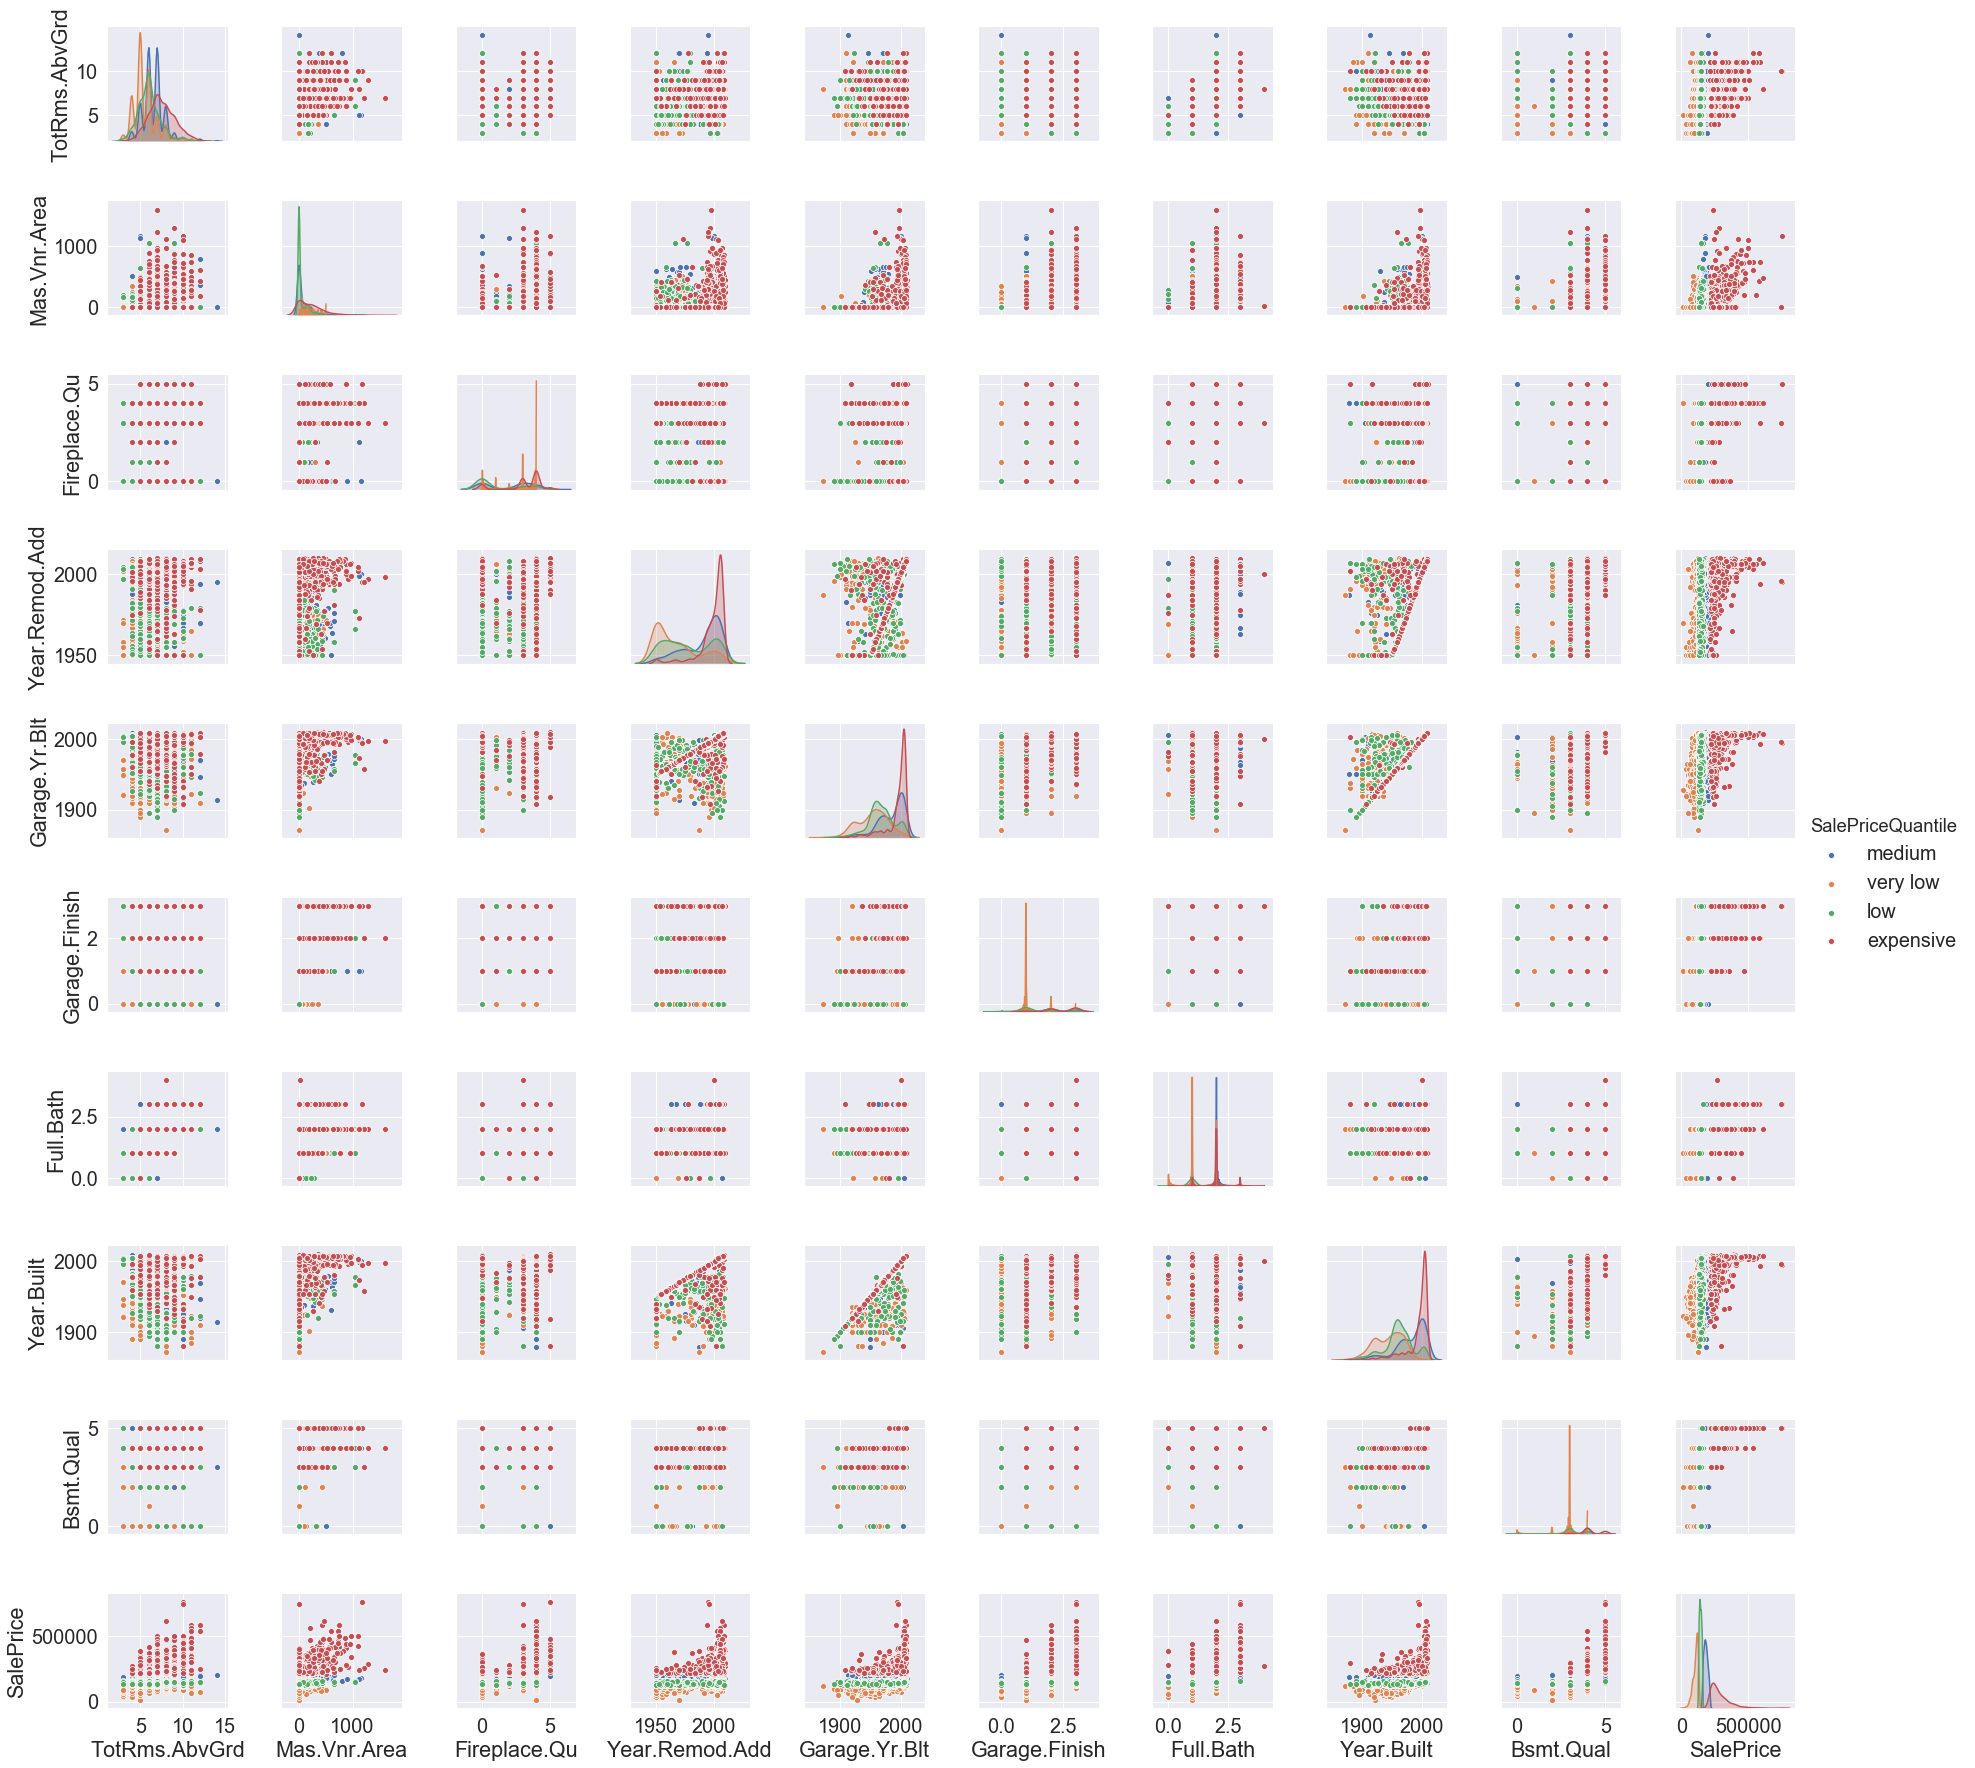

In [46]:
sns.pairplot(data=df_corr1, hue='SalePriceQuantile')
plt.show()

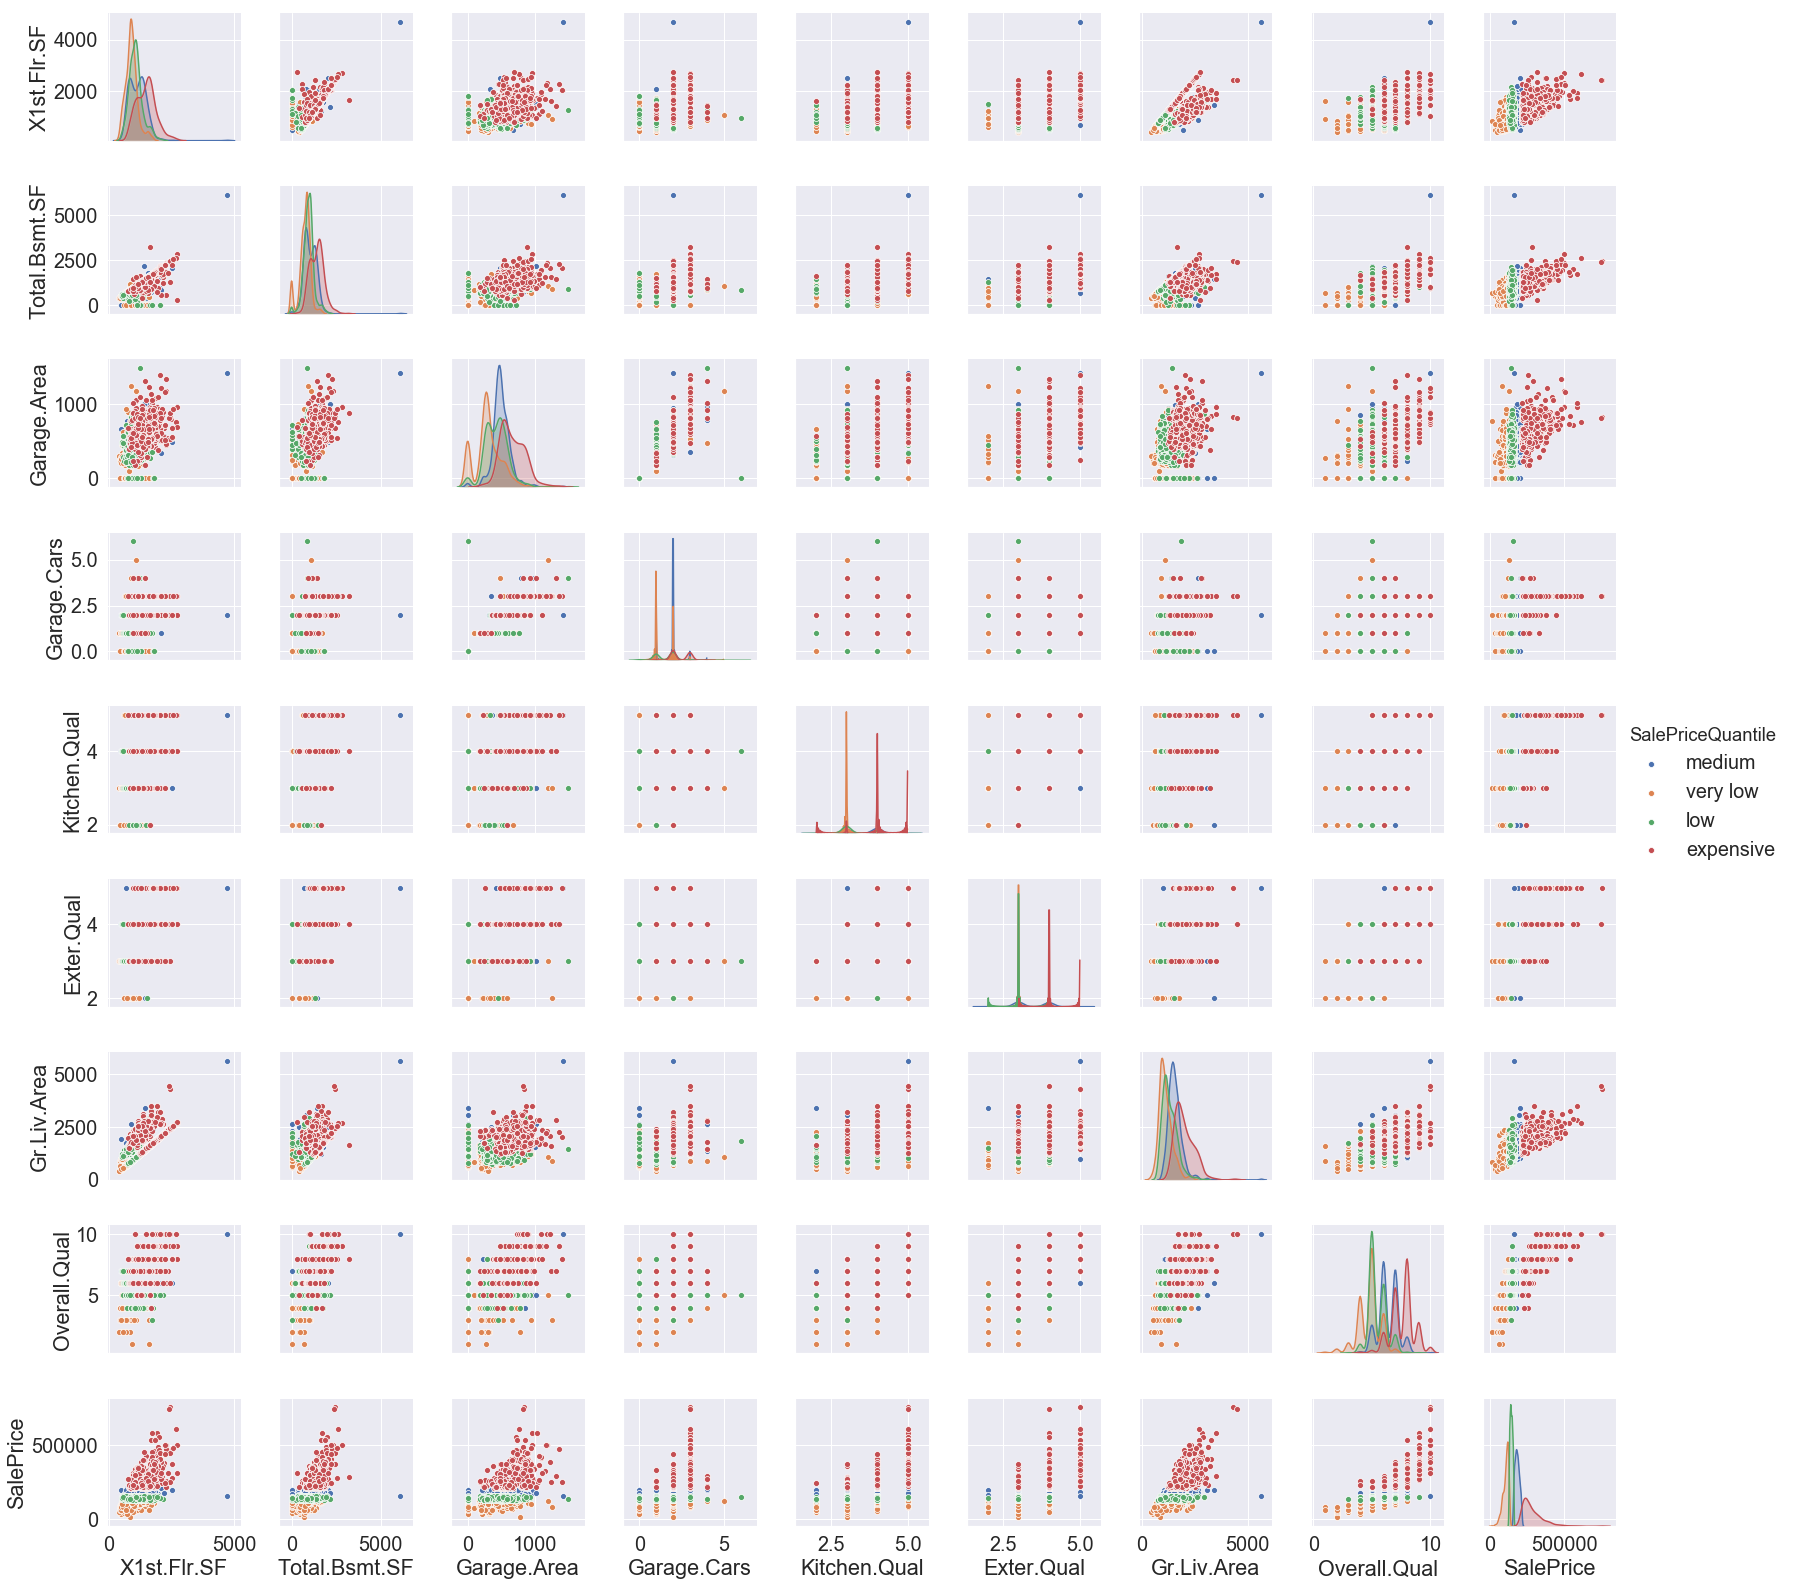

In [47]:
sns.pairplot(data=df_corr2, hue='SalePriceQuantile')
plt.show()

### Pozostałe obserwacje

Sprawdzam czy okolica ma znaczenie jeśli chodzi o liczbę sprzedanych domów. Ponieważ kolumna 'Neighborhoods' została już skonwertowana do danych numerycznych, to do wykonania badania wykorzystam kopię danych. 

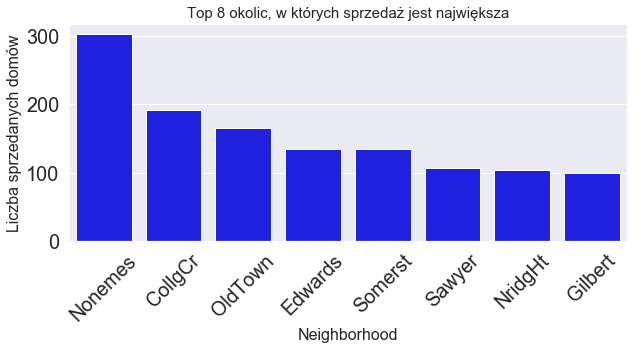

In [48]:
plt.figure(figsize=(10,4))

sns.countplot(x='Neighborhood', data=df_copy, order = df_copy['Neighborhood'].value_counts()[:8].index, color='blue')
plt.title("Top 8 okolic, w których sprzedaż jest największa", fontsize=15) 
plt.xlabel("Neighborhood", fontsize=16)
plt.ylabel("Liczba sprzedanych domów", fontsize=16)
plt.xticks(rotation=45)

sns.set_context(font_scale=2.0) 
plt.show()

Wyraźną popularnością jeśli chodzi o sprzedaż domów cieszy się okolica Nonemes. 

### Podział zbioru na dane treningowe i testowe

Ponieważ w kolejnych krokach na danych zostaną wykonane pewne przekształcenia oraz uzupełnienia w brakach danych, to na tym etapie nastąpi podział danych na treningowe i testowe.
Przyjmuję podział 70% na train oraz 30% na test. Na wszelki wypadek tworzę kopię zapasową danych.
Ponadto usuwam dane tzw. 'information leaks', tzn dane niosące informację z przyszłości, tj po sprzedaży domu oraz dodaną wcześniej zmienną 'SalePriceQuantile'.

Zmienna 'SalePrice' będzie moją zmienną objaśnianą.

In [49]:
df_data = df.drop(['SalePrice', 'Mo.Sold','Yr.Sold','Sale.Type','Sale.Condition','SalePriceQuantile'], axis=1)
df_target = df['SalePrice']
y=df_target
X=df_data

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [51]:
X_train.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val
836,160,2,30,3180,1,2,0,3,4,0,23,2,2,4,5,7,5,2005,2005,1,1,7,8,3,0,3,3,2,4,3,3,6,0,6,0,600,600,1,0,1,4,520,600,80,1200,0,0,2,1,2,1,4,4,0,0,0,5,2005,2,2,480,3,3,2,0,166,0,0,0,0,0,0,1,0
575,20,5,98,11478,1,1,0,3,4,0,18,2,2,0,2,8,5,2007,2008,1,1,11,13,4,200,4,3,2,5,3,3,2,1218,6,0,486,1704,1,0,1,4,1704,0,0,1704,1,0,2,0,3,1,4,7,0,1,4,1,2008,2,3,772,3,3,2,0,50,0,0,0,0,0,0,1,0
557,20,5,69,12160,1,1,1,3,4,0,17,2,2,0,2,5,5,1959,1959,3,1,8,10,1,180,3,3,1,3,3,3,5,1000,6,0,188,1188,1,1,1,4,1188,0,0,1188,1,0,1,0,3,1,3,6,0,0,0,1,1959,2,2,531,3,3,2,0,0,0,0,0,0,0,3,1,0
1235,30,6,60,5400,1,1,0,3,4,0,19,2,2,0,2,7,6,1920,2006,1,1,10,12,3,0,4,3,1,3,3,3,6,0,6,0,931,931,1,4,1,4,1027,0,0,1027,0,1,1,0,2,1,4,5,0,1,3,6,1920,0,0,0,0,0,0,0,28,0,0,0,0,0,0,1,0
1360,20,5,65,8125,1,1,0,3,4,0,17,2,2,0,2,5,7,1959,1959,3,1,7,8,3,0,3,3,1,3,3,3,1,403,6,0,461,864,1,0,1,4,864,0,0,864,0,0,1,0,3,1,3,5,0,0,0,5,1960,1,1,308,3,3,2,0,0,0,0,0,0,0,0,1,0


### Skośność oraz rozkład zbioru

Sprawdzam jak wyglądają różnice między średnią a medianą zbioru - badam skośność.

Współczynnik o wartości 0, to rozkład symetryczny.<br>
Współczynnik o wartości ujemnej to rozkład lewostronnie skośny (wydłużone lewe ramię rozkładu; średnia mniejsza od mediany).<br>
Współczynnik o wartości dodatniej to rozkład prawostronnie skośny (wydłużone prawe ramię rozkładu; średniej większa od mediany).

In [52]:
X_train.skew()

MS.SubClass         1.416002
MS.Zoning          -2.505898
Lot.Frontage        1.739301
Lot.Area           13.692178
Street            -14.050907
Alley              -0.760415
Lot.Shape           1.314888
Land.Contour       -3.298639
Lot.Config         -1.176268
Land.Slope          5.061746
Neighborhood       -0.314753
Condition.1         3.081502
Condition.2        11.264628
Bldg.Type           2.260782
House.Style         0.313740
Overall.Qual        0.257339
Overall.Cond        0.599440
Year.Built         -0.572683
Year.Remod.Add     -0.393325
Roof.Style          1.567911
Roof.Matl           7.945474
Exterior.1st       -0.671652
Exterior.2nd       -0.686588
Mas.Vnr.Type       -0.625684
Mas.Vnr.Area        2.491863
Exter.Qual          0.825475
Exter.Cond          1.666917
Foundation          0.042806
Bsmt.Qual          -1.274858
Bsmt.Cond          -3.599469
Bsmt.Exposure      -1.157885
BsmtFin.Type.1      0.085933
BsmtFin.SF.1        0.839979
BsmtFin.Type.2     -2.929001
BsmtFin.SF.2  

Dla poszczególnych zmiennych można zauważyć rozkłady zarówno lewostronne jak i prawostronne. W szczególności interesuje nas rozkład zmiennej 'SalePrice'. Współczynnik skośności wskazuje że jest to rozkład prawostronnie skośny.

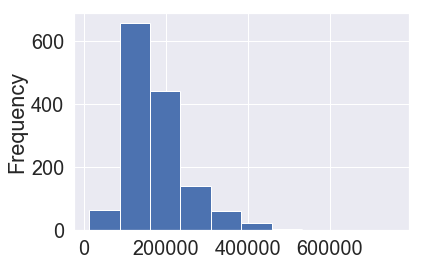

In [53]:
y_train.plot.hist()

Potwierdza to distplot, na którym wyraźnie widać skośność.

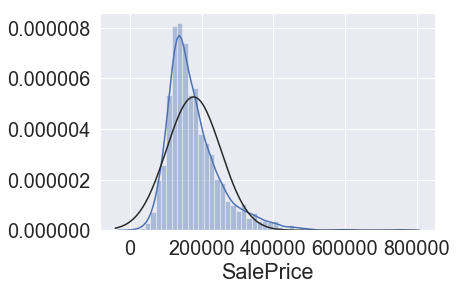

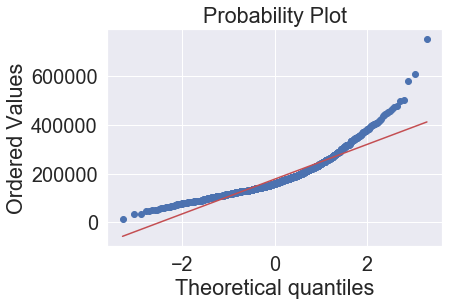

In [54]:
sns.distplot(y_train, fit=stats.norm)
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)

W związku z powyższym w celu uzyskania rozkładu normalnego, skorzystam z logarytmu. Wykonuję transformację.

In [55]:
y_train = np.log(y_train)

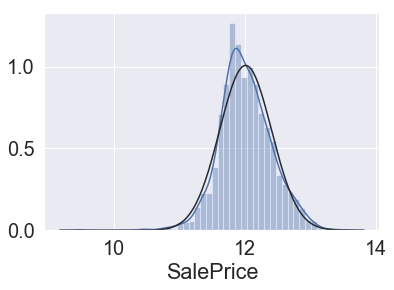

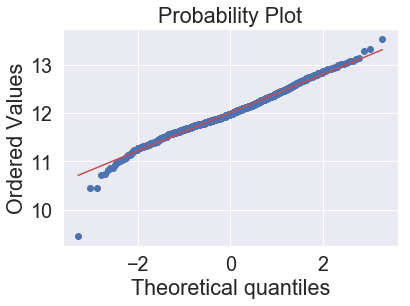

In [56]:
sns.distplot(y_train, fit=stats.norm)
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)

Po wykonaniu transformacji przy użyciu logarytmu, rozkład jest już bardzo zbliżony do normalnego. Również proability plot wygląda lepiej. Końce wykresu nie są już tak odstające od asymptoty. Dla utrzymania spójności danych y_test również zostają zlogarytmowane.

In [57]:
y_test = np.log(y_test)

### PCA - ustalenie liczby komponentów

Ponieważ badany zbiór ma dużą liczbę kolumn, to przy użyciu metody PCA ustalam jaka liczba komponentów ma znaczenie w dalszej analizie.

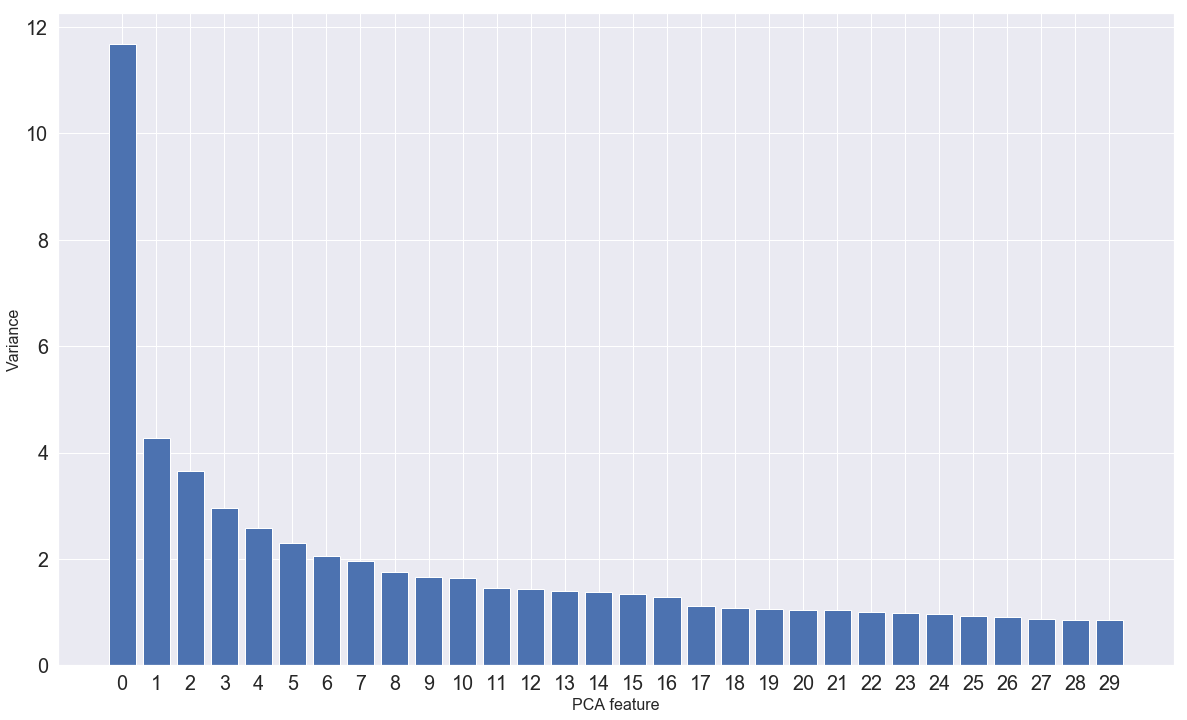

In [58]:
scaler = StandardScaler()
pca = PCA(30)
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X_train, y_train)

features = range(pca.n_components_)
plt.figure(figsize=(20,12))
plt.bar(features, pca.explained_variance_)

plt.xlabel("PCA feature", fontsize=16)
plt.ylabel("Variance", fontsize=16)

plt.xticks(features)
plt.show()

Pierwotnie wykres był rysowany bez podania w PCA liczby feature, jednakze po bliższym przyjrzeniu się wynikom, wykres z 74 kolumnami był niezbyt czytelny. Ponadto zależy mi na zredukowaniu wymiarów.
Dlatego w kolejnym podejściu badane jest już PCA(30). Na tej podstawie wnioskuję, że 17 (0-16) wymiarów wystarczy do przeprowadzenia analizy i taka wartość zostanie ustawione jako n_components.

### Uczenie modeli - porównanie różnych metod regresji

Kolejnym etapem będzie uczenie modeli różnymi metodami. Do wyznaczenia najlepszych parametrów zostanie użyta w każdym przypadku metoda GridSearch.
Uwaga: 
Liczba parametrów param_grid została ograniczona. Poniżej pozostawiono kombinacje zawierające najlepsze parametry, nie będące wartościami brzegowymi listy. Przy jednorazowym podaniu większej liczby parametrów dla niektórych modeli, algorytm niestety kończy się błędem 'Memory error' (ograniczenie pamięci komputera autora analizy).     

Do uczenia zastosuję podział na 5 foldów.

In [59]:
kfold = model_selection.KFold(n_splits=5, random_state=42)
pca = PCA(random_state=42, n_components=17)
scaler = StandardScaler()

### Metoda ElasticNet

In [60]:
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4],
    'elasticnet__alpha': [0.001, 0.01, 0.05, 0.1, 1, 10],
}

polynomialfeatures = PolynomialFeatures()
elasticnet = ElasticNet(tol=0.1, random_state=42)

pipeline = make_pipeline(scaler, pca, polynomialfeatures, elasticnet)

grid_1 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, refit=True, scoring='r2')

time_learn_start = time.time()
grid_1.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_1 = time_learn_stop - time_learn_start
grid_1.best_params_

{'elasticnet__alpha': 0.01, 'polynomialfeatures__degree': 2}

In [61]:
metrics.r2_score(y_train, grid_1.predict(X_train))

0.896548973794344

### Metoda Lasso

In [62]:
param_grid = {
    'polynomialfeatures__degree': [2, 3, 4, 5, 6],
    'lasso__alpha': [200, 300, 400, 500],
}

polynomialfeatures = PolynomialFeatures()
lasso = Lasso(random_state=42)

pipeline = make_pipeline(scaler, pca, polynomialfeatures, lasso)

grid_2 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, refit=True, scoring='r2')

time_learn_start = time.time()
grid_2.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_2 = time_learn_stop - time_learn_start
grid_2.best_params_

{'lasso__alpha': 300, 'polynomialfeatures__degree': 5}

In [63]:
metrics.r2_score(y_train, grid_2.predict(X_train))

0.2962257957901778

### Metoda Ridge

In [64]:
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4],
    'ridge__alpha': [1, 10, 50, 100, 500, 1000], 
}

polynomialfeatures = PolynomialFeatures()
ridge = Ridge(random_state=42)

pipeline = make_pipeline(scaler, pca, polynomialfeatures, ridge)

grid_3 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, refit=True, scoring='r2')

time_learn_start = time.time()
grid_3.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_3 = time_learn_stop - time_learn_start
grid_3.best_params_

{'polynomialfeatures__degree': 1, 'ridge__alpha': 50}

In [65]:
metrics.r2_score(y_train, grid_3.predict(X_train))

0.8706798300706737

### Metoda Linear Regression

In [66]:
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4], 
    }

polynomialfeatures = PolynomialFeatures()
linearregression = linear_model.LinearRegression()

pipeline = make_pipeline(scaler, pca, polynomialfeatures, linearregression)

grid_4 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, refit=True, scoring='r2')

time_learn_start = time.time()
grid_4.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_4 = time_learn_stop - time_learn_start
grid_4.best_params_

{'polynomialfeatures__degree': 1}

In [67]:
metrics.r2_score(y_train, grid_4.predict(X_train))

0.8707211559200995

### Metoda Random Forest Regressor

In [68]:
param_grid = {
    'randomforestregressor__n_estimators': [700, 1200, 1500, 1900], # liczba drzew
    'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 
}

rfc = RandomForestRegressor(n_jobs=-1, oob_score = True, random_state=42) 
pipeline = make_pipeline(scaler, pca, rfc)

grid_5 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, refit=True, scoring='r2')

time_learn_start = time.time()
grid_5.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_5 = time_learn_stop - time_learn_start
grid_5.best_params_

{'randomforestregressor__max_features': 'auto',
 'randomforestregressor__n_estimators': 1900}

In [69]:
metrics.r2_score(y_train, grid_5.predict(X_train))

0.9718489589255965

### Metoda XGBoost

In [84]:
param_grid = {
    'xgbregressor__n_estimators': [300, 500, 700, 900],
    'xgbregressor__max_depth' : [1, 2, 3], 
    'xgbregressor__learning_rate' : [0.01, 0.05, 0.1, 0.5]
}

xg_rg = xgb.XGBRegressor(colsample_bytree=0.4, gamma=0, min_child_weight=1.5, reg_alpha=0.75, reg_lambda=0.45, subsample=0.6,
                 seed=42)

pipeline = make_pipeline(scaler, pca, xg_rg)

grid_6 = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, refit=True, n_jobs=-1, scoring='r2')

time_learn_start = time.time()
grid_6.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_6 = time_learn_stop - time_learn_start
grid_6.best_params_

{'xgbregressor__learning_rate': 0.05,
 'xgbregressor__max_depth': 3,
 'xgbregressor__n_estimators': 700}

In [85]:
metrics.r2_score(y_train, grid_6.predict(X_train))

0.9470823919450355

### Testowanie modeli - predykcja dla każdego modelu

Etap uczenia został zakończony. Dla każdego modelu znaleziono najlepsze parametry. W kolejnym kroku, dla tych parametrów zostanie wykonana predycja zmiennej 'SalePrice'.
Do oceny, który model jest faktycznie najlepszy posłużą mi metryki:

- r2
- explained_variance_score
- median_absolute_error
- mean_squared_error
- mean_absolute_error

In [72]:
models = []
models.append(('ElasticNet', grid_1.best_estimator_, time_of_learning_1))
models.append(('Lasso', grid_2.best_estimator_, time_of_learning_2))
models.append(('Ridge', grid_3.best_estimator_, time_of_learning_3))
models.append(('LinearRegression', grid_4.best_estimator_, time_of_learning_4))
models.append(('RandomForestRegressor', grid_5.best_estimator_, time_of_learning_5))
models.append(('XGBoost', grid_6.best_estimator_, time_of_learning_6))

r2_train = []
r2_test = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []
for name, model, time in models:
    r2_train.append(metrics.r2_score(y_train, model.predict(X_train)))
    r2_test.append(metrics.r2_score(y_test, model.predict(X_test)))
    explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
    median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
    mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))

In [73]:
df_models = pd.DataFrame(data=models)
df_models.rename({0 : 'Name', 1 : 'Model', 2 : 'Time of learning [s] (train)'}, axis = 1, inplace=True)
df_models.drop(labels=['Model'], axis=1, inplace=True)
df_models.set_index('Name', inplace=True)
df_models['R2 (train)'] = r2_train
df_models['R2 (test)'] = r2_test
df_models['Explained variance score (test)'] = explained_variance_score
df_models['Median absolute error (test)'] = median_absolute_error
df_models['Mean squared error (test)'] = mean_squared_error
df_models['Mean absolute errors (test)'] = mean_absolute_error
df_models

,Time of learning [s] (train),R2 (train),R2 (test),Explained variance score (test),Median absolute error (test),Mean squared error (test),Mean absolute errors (test)
Name,,,,,,,
ElasticNet,50.117658,0.896549,0.868631,0.869081,0.074327,0.022041,0.097395
Lasso,2986.469499,0.296226,-12.434159,-12.429086,0.231086,2.253961,0.324760
Ridge,37.262985,0.870680,0.830844,0.831147,0.077132,0.028381,0.105501
LinearRegression,17.090171,0.870721,0.830272,0.830571,0.077302,0.028477,0.105674
RandomForestRegressor,340.584286,0.971849,0.870620,0.871029,0.077342,0.021707,0.104447
XGBoost,40.549975,0.931920,0.885587,0.885854,0.073289,0.019196,0.098506


Wnioski: 

 - na etapie uczenia, badając kryterium R2, najlepszym modelem okazał się 'RandomForestRegressor'. R2 na danych treningowych wyszło najwyższe, jednakże R2 na danych testowych, pomimo, że wysokie to jednak znacznie odbiegające od wyniku na zbiorze treningowym, ma też najgorszy czas uczenia
 - drugi najlepszy wynik to 'XGBoost', R2 na danych testowych również znacząco różne od wyniku na danych treningowych
 - trzeci wynik to 'ElasticNet', dla tego modelu różnica między R2 na danych treningowych i testowych jest najmniejsza, a wynik R2 (test) jest bardzo podobny dla otrzymanych wyników dla modeli 'RandomForestRegressor' oraz 'XGBoost', także jego czas uczenia jest stosunkowo krótki
 - najgorszym modelem, już na etapie uczenia okazał się 'Lasso', wynik R2 na zbiorze treningowym był mocno niezadowalający, a na zbiorze testowym jest wręcz bardzo zły, model całkowicie nie nadaje się do uczenia na tym zbiorze danych

### Porównanie wyników przewidzianych oraz rzeczywistych

Otrzymane wyniki - ceny domów obliczone przez modele oraz rzeczywiste ceny zapisuję w plikach wynikowych csv. Na tym etapie rezygnuję z dalszej analizy modelu 'Lasso'.

In [74]:
models[1]

('Lasso', Pipeline(memory=None,
      steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=17, random_state=42,
   svd_solver='auto', tol=0.0, whiten=False)), ('polynomialfeatures', PolynomialFeatures(degree=5, include_bias=True, interaction_only=F...ive=False, precompute=False, random_state=42,
    selection='cyclic', tol=0.0001, warm_start=False))]), 2986.469499349594)

In [75]:
models.remove(models[1])

In [76]:
comparison_sale_price = []
models_lst = ['ElasticNet', 'Ridge', 'LinearRegression', 'RandomForestRegressor', 'XGBoost']
results_names = ['OriginalSalePrice', 'PredictedSalePrice']
file_names_lst = []

i = 0
for name, model, time in models:
    predictions = model.predict(X_test)
    predictions = predictions.astype('float')
    comparison_sale_price = pd.DataFrame({
           results_names[0] : y_test,
           results_names[1] : predictions
        })
    file_name = 'Results_'+models_lst[i]+'.csv'
    file_names_lst.append(file_name)
    comparison_sale_price.to_csv('./data/'+file_name, index=False)
    i += 1

Następnie sprawdzam jak bardzo się różnią na wykresach. Wykresy przedstawiają wartości przewidywane oraz rzeczywiste po zlogarytmowaniu.

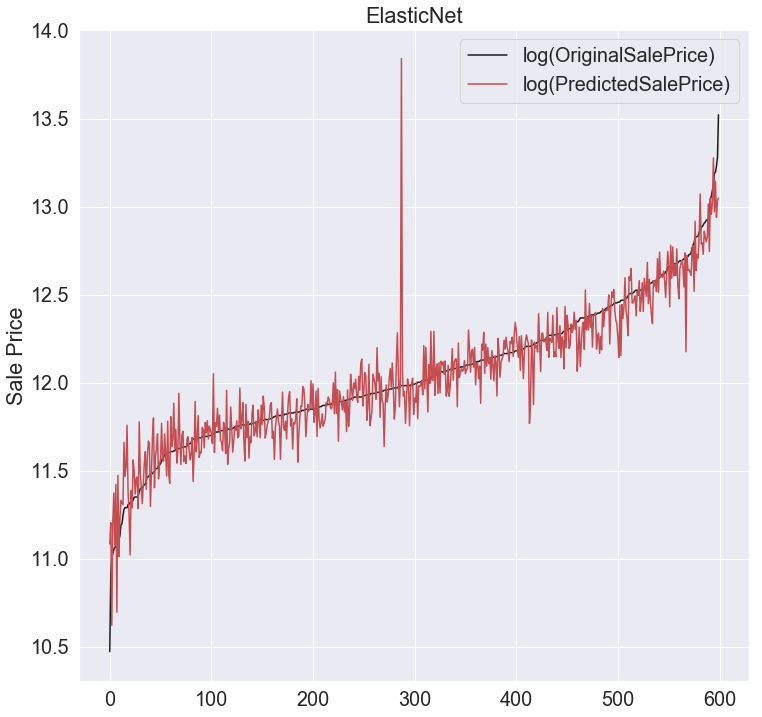

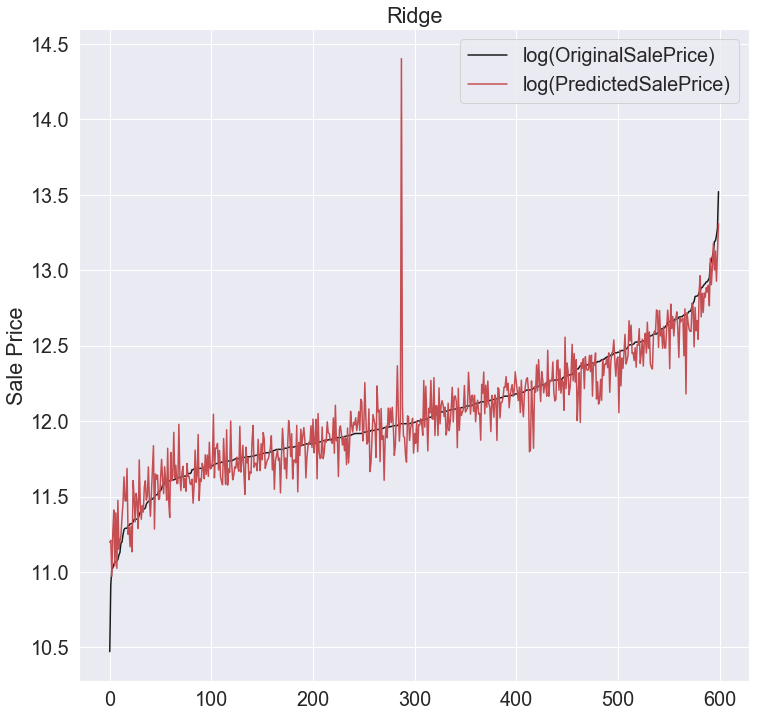

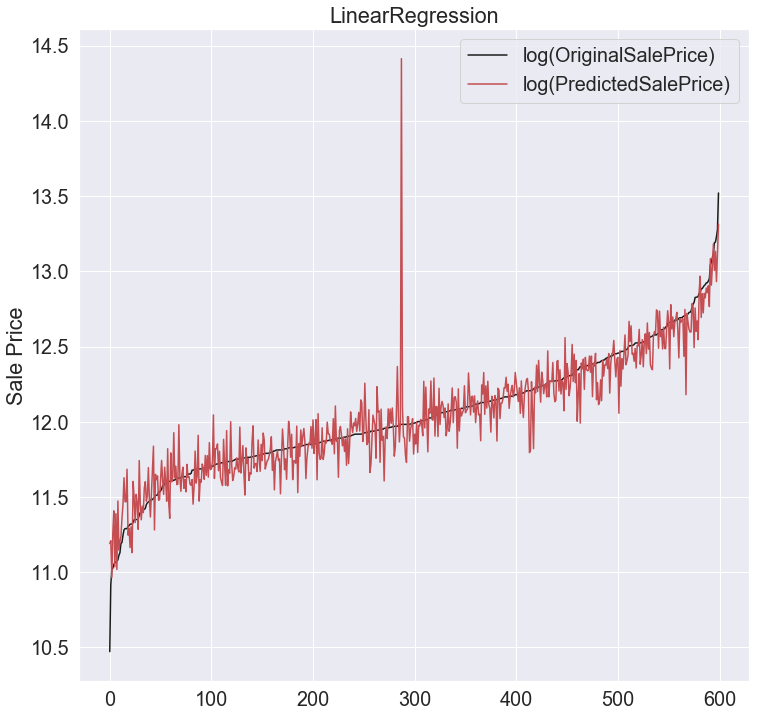

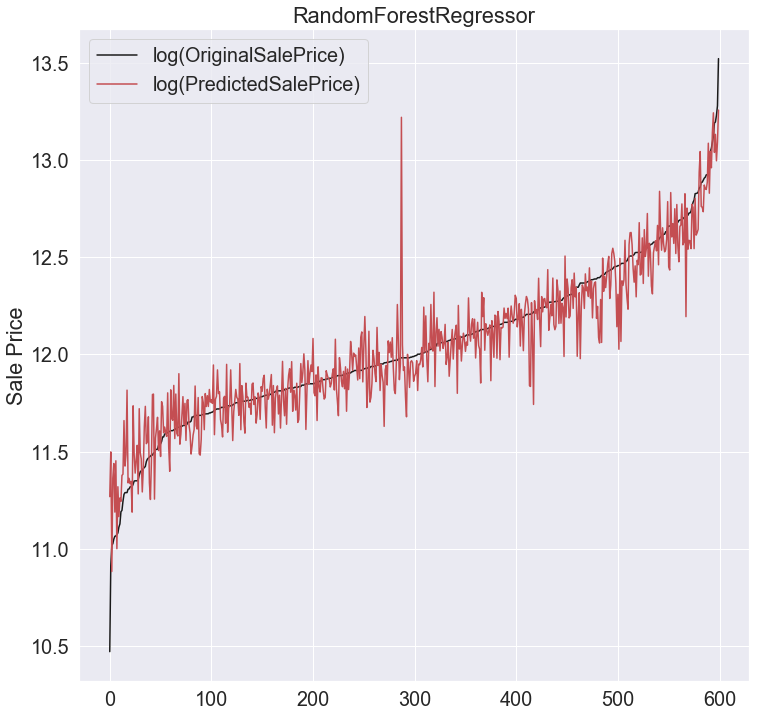

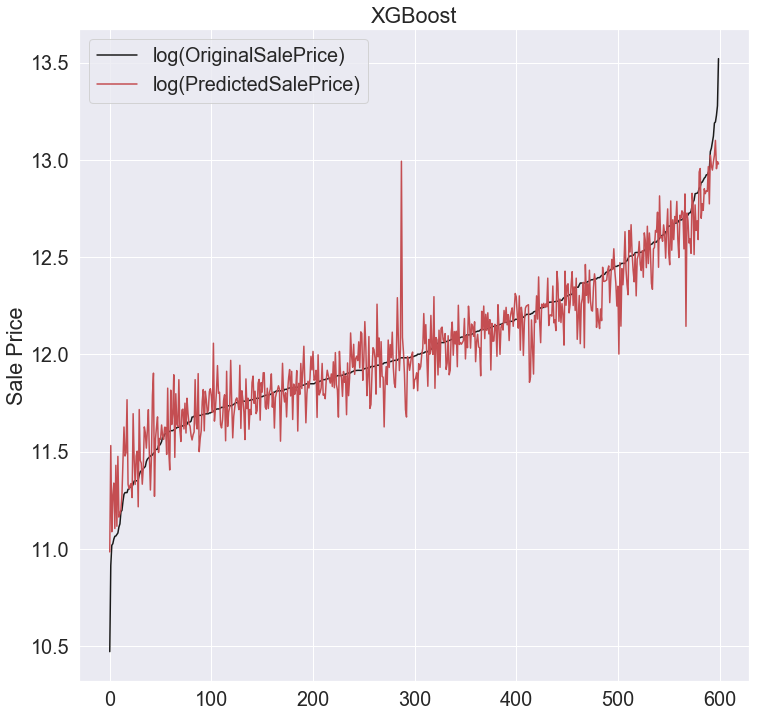

In [77]:
i = 0
for result in file_names_lst:
    results = pd.read_csv('./data/'+file_names_lst[i])
    pd_results = pd.DataFrame(results)
    pd_results.sort_values(by='OriginalSalePrice', ascending=True, inplace=True)
    
    plt.figure(figsize=(12,12))
    plt.plot(range(600), pd_results['OriginalSalePrice'], '-k', label='log(OriginalSalePrice)')
    plt.plot(range(600), pd_results['PredictedSalePrice'], '-r', ms=10, label='log(PredictedSalePrice)')
    plt.ylabel('Sale Price')
    plt.title(models_lst[i])
    plt.legend()
    plt.show()
    i += 1

Wnioski:
    
 - wartości przewidywane różnią się w podobny sposób we wszystkich modelach (poza 'Lasso')
 - żaden z modeli nie poradził sobie z jednym rekordem w zbiorze, wynik przewidywany drastycznie odbiega od rzeczywistego (widoczny pik na każdym z wykresów)

### Ocena graficzna predykcji modeli - średnia i odchylenie standardowe dla R2

Na najlepszych parametrach dla każdego modelu wykonuję cross walidację aby policzyć dla nich wyniki cząstkowe R2.

In [78]:
results = []
names = []
means_r2 = []
stds_r2 = []
for name, model, time in models:
    cv_results = cross_val_score(model, X_test, y_test, cv=kfold, scoring='r2')
    results.append(cv_results)
    means_r2.append(cv_results.mean())
    stds_r2.append(cv_results.std())
    names.append(name)

In [79]:
df_models2 = pd.DataFrame(data=[names, means_r2, stds_r2]).transpose()
df_models2.rename(columns={0: 'Name', 1: 'Mean R2 (test)', 2: 'Std R2 (test)'}, inplace=True)
df_models2.set_index('Name', inplace=True)
df_models2

,Mean R2 (test),Std R2 (test)
Name,,
ElasticNet,0.779701,0.149548
Ridge,0.784853,0.128748
LinearRegression,0.782532,0.132764
RandomForestRegressor,0.85128,0.0241864
XGBoost,0.840382,0.0302079


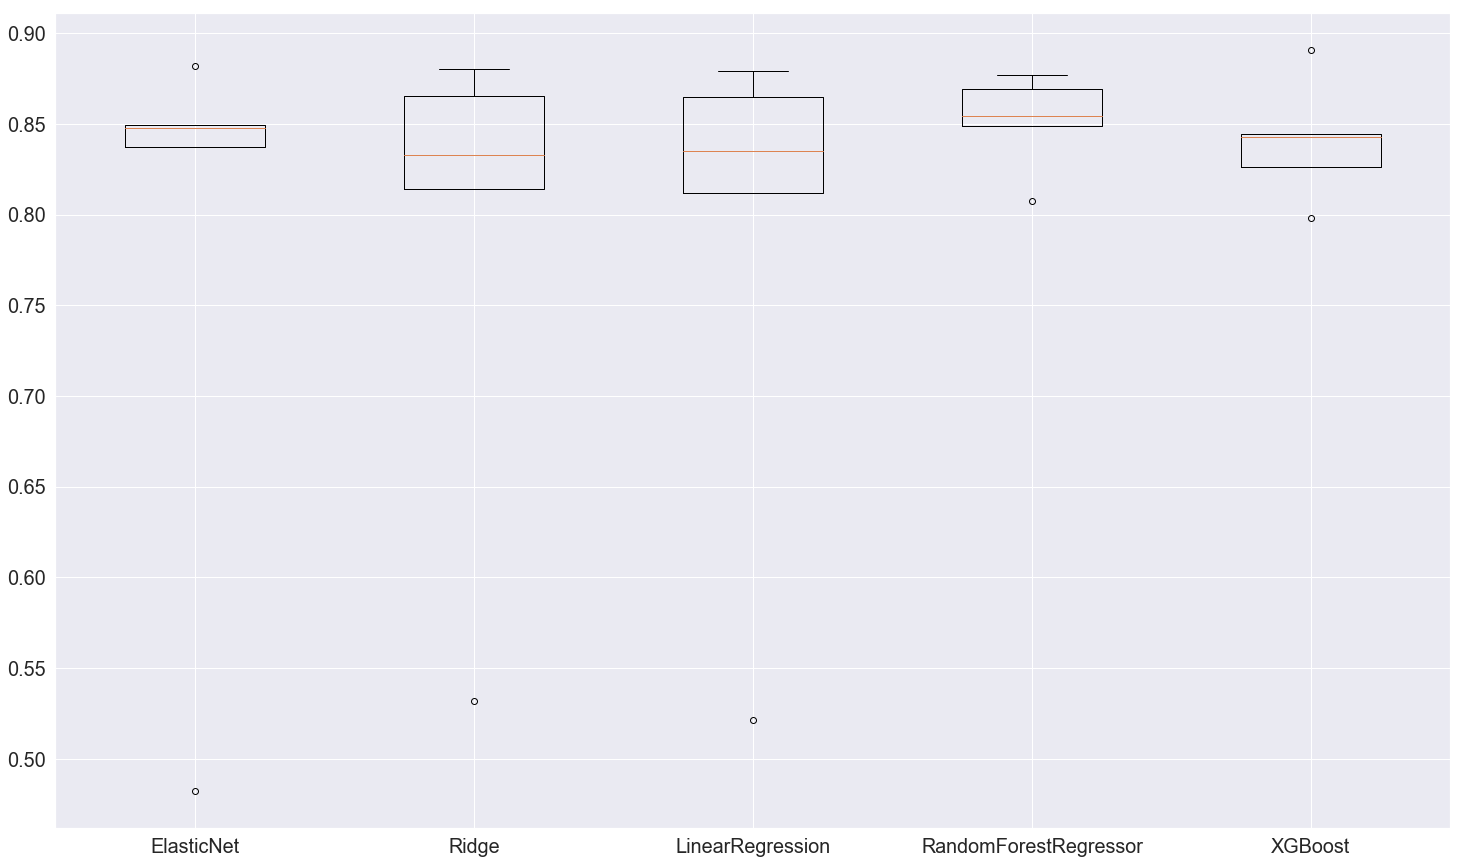

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
plt.boxplot(results)
axes.set_xticklabels(names)
plt.show()

Wnioski:
    